In [175]:
import datetime
import pickle
import re

import lxml.etree as etree
import requests

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from nltk.corpus import stopwords
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')
stop_words_list = stopwords.words('english')
ns = {"mods": "http://www.loc.gov/mods/v3"}

In [132]:
def get_mods(druid: str):
    purl_url = f"https://purl.stanford.edu/{druid}.mods"
    try:
        purl_result = requests.get(purl_url)
    except:
        print(f"Request error for {druid} with {purl_url}")
        return ''
    try:
        purl_xml = etree.XML(purl_result.text.encode())
    except etree.XMLSyntaxError:
        print(f"\nXML Syntax Error for {druid}")
        return ''
    return purl_xml
    
def get_abstract(purl_xml):
    abstract = purl_xml.find("mods:abstract", namespaces=ns)
    if abstract is not None:
        return abstract.text

def get_department(purl_xml):
    corporate_names = purl_xml.findall("mods:name[@type='corporate']/mods:namePart", namespaces=ns)
    department = []
    for name in corporate_names:
        if name.text.startswith("Stanford University"):
            continue
        department.append(name.text)
    return ','.join(department)

special_char_re = re.compile(r'[^a-zA-Z]')

def cleanup(term: str) -> str:
    cleaned = []
    for char in term.split():
        cleaned_char = special_char_re.sub(' ', char).lower()
        if cleaned_char in stop_words_list:
            continue
        cleaned.append(cleaned_char)
    return ' '.join(cleaned)

In [34]:
biology_df = pd.read_pickle("data/biology.pkl")

In [68]:
biology_df.head()

,druids,abstracts,abstracts_cleaned,departments
0,zd879dy3740,Circumstantial evidence suggests vast post-tra...,circumstantial evidence suggests vast post tra...,Department of Biochemistry.
1,sc349gp0346,The brain is a complex organ formed from billi...,brain complex organ formed billions neurons t...,Department of Biology.
2,gh439vr9294,Because of their capability of assembling hier...,capability assembling hierarchically stable or...,Department of Chemistry
3,qv108wv0750,L-type voltage-gated calcium channels (LTCs) p...,l type voltage gated calcium channels ltcs p...,Neurosciences Program.
4,cr369nn5134,"During cell division, chromosome segregation m...",cell division chromosome segregation must coo...,Department of Biochemistry


In [87]:
biology_df['abstracts'].isnull().sum()

247

In [103]:
missing_info = []
for i,row in enumerate(biology_df['abstracts'].isnull()):
    if row:
        missing_info.append(biology_df.iloc[i])

In [104]:
len(missing_info)

247

In [105]:
missing_info[0]

druids               bz168ds1940
abstracts                    NaN
abstracts_cleaned            NaN
departments                  NaN
Name: 116, dtype: object

In [114]:
xml = get_mods('bz168ds1940')

In [122]:
get_department(xml)

'Department of Chemistry'

In [127]:
get_abstract(xml)

'Despite numerous advances in metal ion sensor design, it is still difficult, slow and laborious to rationally design, synthesize and optimize selective sensors for each individual metal ion for a wide variety of metal cations. In order to develop an approach to rapidly generate sensors for many different metal cations, a new molecular sensor design strategy based on DNA-like oligomers (oligodeoxyfluorosides or ODFs) was investigated. The ODF-based design incorporates fluorophores and metal ligands onto the DNA backbone, allowing the binding and reporting moieties to interact intimately by bringing them into direct contact by pi-pi stacking, analogous to the stacking of DNA bases. The highly modular molecular design allows for water solubility and enables rapid synthesis and discovery of sensors from combinatorial libraries. Using the ODF-based sensor design and a combinatorial library approach, a wide variety of metal ion sensors were discovered for many different metal cations. A sel

In [128]:
missing_info[0]['abstracts'] = get_abstract(xml)

In [133]:
missing_info[0]['druids']

'bz168ds1940'

In [154]:
def populate_missing(missing_info):
    start = datetime.datetime.utcnow()
    print(f"Starting at {start} for {len(missing_info)}")
    for i,row in enumerate(missing_info):
        druid = row['druids']
        xml = get_mods(druid)
        if len(xml) < 1:
            print(f"XML is empty for {druid}, index {i}")
            continue
        row['departments'] = get_department(xml)
        abstract = get_abstract(xml)
        if abstract is None:
            print(f"No abstract for {druid}, index {i}")
            abstract = ''
        row['abstracts'] = abstract
        row['abstracts_cleaned'] = cleanup(abstract)

    end = datetime.datetime.utcnow()
    print(f"Finished at {end} total time {(end-start).seconds / 60.} mins")

In [153]:
populate_missing()

Starting at 2020-10-21 20:42:47.660303 for 247
No abstract for dg421jb1685, index 15
Finished at 2020-10-21 20:44:04.694893 total time 1.2833333333333334 mins


In [150]:
missing_info[156]['druids'] = 'yq505mb7923'

In [160]:
print(missing_info[15])

druids                         dg421jb1685
abstracts                                 
abstracts_cleaned                         
departments          Department of Biology
Name: 216, dtype: object


In [159]:
missing_info[15]['departments'] = 'Department of Biology'

In [161]:
biology_df.tail()

,druids,abstracts,abstracts_cleaned,departments
1138,xr773zb6840,Some of our earliest artisans were pioneers of...,earliest artisans pioneers nanoengineering bu...,Department of Chemistry.
1139,xs043wz4950,Salmonella enterica serovars can cause a range...,salmonella enterica serovars cause range disea...,Program in Immunology.
1140,rh679rc9667,Pregnancy is a complicated process were the ma...,pregnancy complicated process maternal body dr...,Department of Genetics.
1141,xq696rs8043,"The impact, pervasivity and regulation of the ...",impact pervasivity regulation two phase separ...,Department of Biology.
1142,pz926bj0175,The 15q13.3 microdeletion is associated with s...,q microdeletion associated several neuro...,Department of Genetics.


In [163]:
biology_df.to_pickle("./data/biology.pkl")

In [164]:
biology_embeddings = sbert_model.encode(biology_df['abstracts_cleaned'])

In [165]:
wcss = []
for i in range(1,50):
    kmeans = KMeans(n_clusters=i, init = 'k-means++', random_state=42)
    kmeans.fit(biology_embeddings)
    wcss.append(kmeans.inertia_)

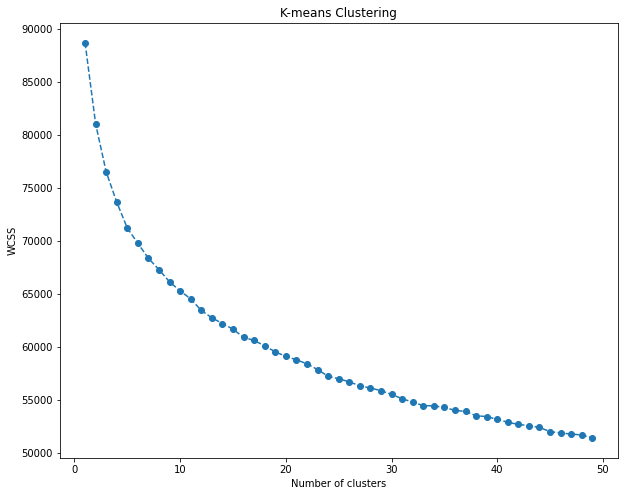

In [167]:
plt.figure(figsize=(10,8))
plt.plot(range(1,50), wcss, marker = 'o', linestyle='--')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.title('K-means Clustering')
plt.show()

In [169]:
clustering_model = KMeans(n_clusters=18)
clustering_model.fit(biology_embeddings)
cluster_assignment = clustering_model.labels_

In [172]:
clustered_sentences = [[] for i in range(18)]
for abstract_id, cluster_id in enumerate(cluster_assignment):
    clustered_sentences[cluster_id].append({ 'abstract': biology_df.iloc[abstract_id]['abstracts'], 
                                             'druid': biology_df.iloc[abstract_id]['druids'] })

In [173]:
for i,row in enumerate(clustered_sentences):
    print(f"Cluster {i} size {len(row)}")

Cluster 0 size 48
Cluster 1 size 83
Cluster 2 size 94
Cluster 3 size 84
Cluster 4 size 63
Cluster 5 size 80
Cluster 6 size 41
Cluster 7 size 43
Cluster 8 size 84
Cluster 9 size 3
Cluster 10 size 39
Cluster 11 size 55
Cluster 12 size 55
Cluster 13 size 91
Cluster 14 size 84
Cluster 15 size 81
Cluster 16 size 52
Cluster 17 size 63


In [174]:
print(clustered_sentences[9][0])
print(f"Last abstract")
print(clustered_sentences[9][-1])

{'abstract': '', 'druid': 'dg421jb1685'}
Last abstract
{'abstract': 'Abstract to be provided.', 'druid': 'bz491tn4091'}


In [177]:
with open('./data/biology-bert-embedding.pkl', 'wb+') as fo:
    pickle.dump(biology_embeddings, fo)

In [3]:
import pandas as pd
bio_df = pd.read_pickle("../biology-etds/data/biology.pkl")

In [4]:
len(bio_df)

1143